# Data Modeling with a Decision Tre

Decision Tree model was added to aid in feature selection.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import pandas as pd
import numpy as np

from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from category_encoders import WOEEncoder, TargetEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.tree._tree import TREE_LEAF

from sklearn.preprocessing import PolynomialFeatures as Poly

from mlxtend.evaluate import feature_importance_permutation

from mlxtend.feature_extraction import PrincipalComponentAnalysis
from mlxtend.preprocessing import standardize

from mlxtend.feature_extraction import RBFKernelPCA as KPCA
from pyearth import Earth

from mlxtend.plotting import plot_pca_correlation_graph

# from umap import UMAP

import warnings
warnings.filterwarnings("ignore")

In [2]:
def stringify(data):
    if type(data) != pd.core.frame.DataFrame:
        X = pd.DataFrame(data)
    else:
        X = data
        
    for c in X.columns.tolist():
        X[c] = X[c].astype(str)
#     X = X.applymap(str)
    return X

objectify = FunctionTransformer(func = stringify, check_inverse = False, validate=False)
binner = KBinsDiscretizer(n_bins = 10, encode = 'ordinal')
poly = Poly(degree=3)
encoder = WOEEncoder()

In [21]:
def plot_tree(dt, used_cols, out_file='mytree.dot'):
    export_graphviz(dt, out_file=out_file, 
                    filled=True, feature_names=used_cols, 
                    leaves_parallel=True, node_ids=True, rotate=True)
    with open(out_file) as f:
        dot_graph = f.read()
    return graphviz.Source(dot_graph)
    

def prune_index(inner_tree, index, threshold):
    if inner_tree.value[index].min() < threshold:
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
    # if there are children, visit them as well
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_index(inner_tree, inner_tree.children_left[index], threshold)
        prune_index(inner_tree, inner_tree.children_right[index], threshold)

In [4]:
df = pd.read_csv('/Users/davidwalkup/ds-course/projects/Mod3/Seattle_Terry_Stops/data/Terry_Stops_added_features.csv')

In [5]:
df.columns

Index(['Subject Age Group', 'Subject ID', 'GO / SC Num', 'Terry Stop ID',
       'Stop Resolution', 'Weapon Type', 'Officer ID', 'Officer YOB',
       'Officer Gender', 'Officer Race', 'Subject Perceived Race',
       'Subject Perceived Gender', 'Reported Date', 'Reported Time',
       'Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad',
       'Arrest Flag', 'Frisk Flag', 'Precinct', 'Sector', 'Beat',
       'subject_age_groups', 'stop_resolution', 'arrest_flag',
       'weapon_present', 'officer_gender', 'officer_race', 'subject_race',
       'subject_gender'],
      dtype='object')

In [6]:
target = 'arrest_flag'

In [7]:
excluded_cols = ['arrest_flag', 'Arrest Flag',
                 'stop_resolution', 'Stop Resolution',
                 'Subject ID', 'Subject Age Group']

In [43]:
# used_cols = [c for c in df.columns if c not in excluded_cols]
used_cols = ['officer_gender', 'Reported Time', 'weapon_present', 'Initial Call Type']
# used_cols = ['officer_gender', 'Reported Time', 'weapon_present']
# used_cols = ['officer_gender', 'weapon_present', 'Initial Call Type']
# used_cols = ['officer_gender', 'Reported Time']
# used_cols = ['Reported Time']
X = df[used_cols]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, 
                                                    test_size=.20, random_state=42, 
                                                    stratify=y.values)

dt = DecisionTreeClassifier(criterion='entropy',
                            max_depth=3,
                            min_samples_leaf=5,
                            random_state=42,
                            class_weight='balanced')

encoder = WOEEncoder()
scorecard = make_pipeline(objectify, encoder, dt)

scores = cross_val_score(scorecard, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.9465560885073678 +/- 0.03197310921976017


In [44]:
X_transformed

,Reported Time
0,0.231792
1,0.432463
2,-0.260684
3,-0.340727
4,-0.203526
...,...
39392,0.000000
39393,0.000000
39394,0.000000
39395,2.224223


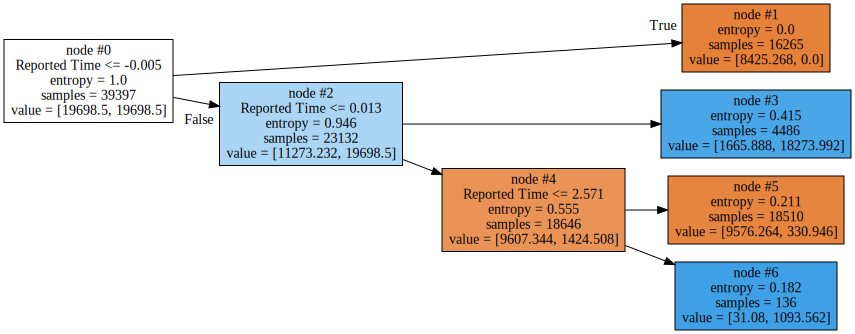

In [45]:
X_transformed = Pipeline(scorecard.steps[:-1]).fit_transform(X, y)
dt.fit(X_transformed, y)
plot_tree(dt, used_cols)

In [65]:
transformed_time = X_transformed.loc[(X_transformed['Reported Time'] > -0.005) &
                                     (X_transformed['Reported Time'] <= 0.013)].index

In [67]:
len(transformed_time)

4486

In [61]:
transformed_time[0]

2

In [64]:
df['Reported Time'].loc[df.index == 2]

2    01:06:00
Name: Reported Time, dtype: object

In [71]:
df.loc[transformed_time].head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Sector,Beat,subject_age_groups,stop_resolution,arrest_flag,weapon_present,officer_gender,officer_race,subject_race,subject_gender
1002,-,-1,20190000196375,8258254438,Field Contact,-,8605,1983,M,Asian,...,S,S3,7,1,0,0,0,4,1,0
1003,-,-1,20190000200272,8261687375,Offense Report,Knife/Cutting/Stabbing Instrument,8575,1984,F,White,...,E,E2,7,2,0,1,1,1,2,0
1004,-,-1,20190000202781,8266022402,Field Contact,-,8492,1989,M,White,...,K,K1,7,1,0,0,0,1,1,0
1023,-,-1,20190000192145,8249776941,Offense Report,-,6686,1969,M,White,...,B,B1,7,2,0,0,0,1,1,0
1024,-,-1,20190000197027,8258979624,Field Contact,-,8461,1982,M,White,...,U,U2,7,1,0,0,0,1,1,0


In [72]:
df_node3 = df.loc[transformed_time]

In [74]:
df_node3.to_csv(path_or_buf = '~/ds-course/projects/Mod3/Seattle_Terry_Stops/data/subset.csv')